## Init

In [2]:
import argparse
import collections
import functools
import json
import imageio
import os
import pathlib
import sys
import time
from PIL import Image
import skvideo.io
import matplotlib

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MUJOCO_GL'] = 'egl'

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.mixed_precision import experimental as prec
from blox.utils import AverageMeter, timing
from blox.basic_types import map_dict
import time
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

from tensorflow_probability import distributions as tfd

# sys.path.append(str(pathlib.Path(__file__).parent))

import models
import tools
import wrappers
from dreamer import Dreamer, preprocess, make_bare_env
import dreamer
import gn_solver
import gn_solver_goal
from utils import logging
from dreamer_colloc import DreamerColloc, make_env
import dreamer_colloc

def define_config():
  config = dreamer_colloc.define_config()

  return config

def fig2img(fig):
    """Converts a given figure handle to a 3-channel numpy image array."""
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w, h, 4)
    buf = np.roll(buf, 3, axis=2)
    w, h, d = buf.shape
    return np.array(Image.frombytes("RGBA", (w, h), buf.tostring()))[:, :, :3]

In [4]:
# Parse arguments
try:
    import colored_traceback
    colored_traceback.add_hook()
except ImportError:
    pass
parser = argparse.ArgumentParser()
for key, value in define_config().items():
    parser.add_argument(f'--{key}', type=tools.args_type(value), default=value)
# args = '--logdir ./logdir/pm_obstacle/far_goal_b01_sr/offline --task colloc_pm_obstacle --action_repeat 1 --time_limit 40 --planning_task colloc_second_order --batch_length 30 --planning_horizon 40 --mpc_steps 40 --gd_steps 200 --logdir_colloc ./logdir/pm_obstacle/far_goal_b01_sr/09_29_denseoffline_40x1_colloc_rw1_dt1e-6_at1e-6_norm1_gd200_-0.4_0_2 --rew_res_wt 1 --dyn_threshold 1e-6 --act_threshold 1e-6 --coeff_normalization 1 --eval_tasks 1 --state_regressor=True --state_size 4 --sparse_reward_model=False'
args = '--logdir ./logdir/pm_obstacle/far_goal_b01_sr/offline --task colloc_pm_obstacle --action_repeat 1 --time_limit 40 --planning_task colloc_second_order --batch_length 30 --planning_horizon 40 --mpc_steps 40 --gd_steps 200 --logdir_colloc ./logdir/pm_obstacle/far_goal_b01_sr/09_29_denseoffline_40x1_colloc_rw1_dt1e-6_at1e-6_norm1_gd200_-0.4_0_2 --rew_res_wt 1 --dyn_threshold 1e-6 --act_threshold 1e-6 --coeff_normalization 1 --eval_tasks 1 --state_regressor=True --state_size 4'
config = parser.parse_args(args.split(' '))

In [5]:
# Build env and agent
if config.gpu_growth:
    for gpu in tf.config.experimental.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
assert config.precision in (16, 32), config.precision
if config.precision == 16:
    prec.set_policy(prec.Policy('mixed_float16'))
config.steps = int(config.steps)
config.logdir.mkdir(parents=True, exist_ok=True)
print('Logdir', config.logdir)
config.logdir_colloc.mkdir(parents=True, exist_ok=True)

# Create environment.
env = make_env(config)

# Create agent.
actspace = env.action_space
datadir = config.logdir / 'episodes'
agent = DreamerColloc(config, datadir, actspace)
agent.load(config.logdir / 'variables.pkl')
cmap = plt.get_cmap()


Logdir logdir/pm_obstacle/far_goal_b01_sr/offline
Choosing the latest nvidia driver: /usr/lib/nvidia-418, among ['/usr/lib/nvidia-375', '/usr/lib/nvidia-418']
Choosing the latest nvidia driver: /usr/lib/nvidia-418, among ['/usr/lib/nvidia-375', '/usr/lib/nvidia-418']


/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Found 5550424 model parameters.
Found 575204 actor parameters.
Found 413601 value parameters.


In [4]:
# Visualize

""" Run planning loop """
# Define task-related variables
assert config.planning_task == 'colloc_second_order'
actspace = env.action_space
obs = env.reset()
obs['image'] = [obs['image']]
# Obtain goal observation for goal-based collocation
is_goal_based = 'goal' in config.planning_task or config.goal_based
if is_goal_based:
    goal_obs = env.render_goal()
    imageio.imwrite('goal_img.jpg', goal_obs['image'])
    goal_obs['image'] = [goal_obs['image']]
else:
    goal_obs = None

## Plot collocation

In [ ]:
act_pred, img_pred, feat_pred, info = agent.collocation_so(obs, goal_obs, True, 0)
plans = info['plans']
# agent.logger.log_video(f"plan/0", img_pred.numpy())

In [47]:
# color = np.linspace(0, 1, 10)
# color
# plt.get_cmap()(1)
# np.save(config.logdir_colloc / 'good_plans_collocation.npy', plans)
plans = np.load(config.logdir_colloc / 'good_plans_collocation.npy')

In [55]:
def plot_map():
    plt.plot([0], [-0.4], 'ro', ms=40)
    plt.plot([0], [0.8], 'rx', mew=4, ms=40)

    # Correct obstacle location: 
    x_min, x_max, y_min, y_max = 0.2, 0.3, -0.45, 0.45
    x_min, x_max, y_min, y_max = 0.2, 0.28, -0.4, 0.4
    plt.plot([y_min, y_max, y_max, y_min, y_min], [x_min, x_min, x_max, x_max, x_min,])
    
    x_min, x_max, y_min, y_max = -0.5, 1, -0.75, 0.75
    plt.plot([y_min, y_max, y_max, y_min, y_min], [x_min, x_min, x_max, x_max, x_min,], color='black', lw=5)

def make_figure_pretty(ax, fig):
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False)
    ax.grid(False)
    plt.axis('off')
    fig.tight_layout()  
    
def get_figure():
    fig = plt.figure(figsize=(18,18))
    ax = plt.gca()
    plt.clf()  # Clear figure
    cmap = plt.get_cmap()
    return fig, ax, cmap

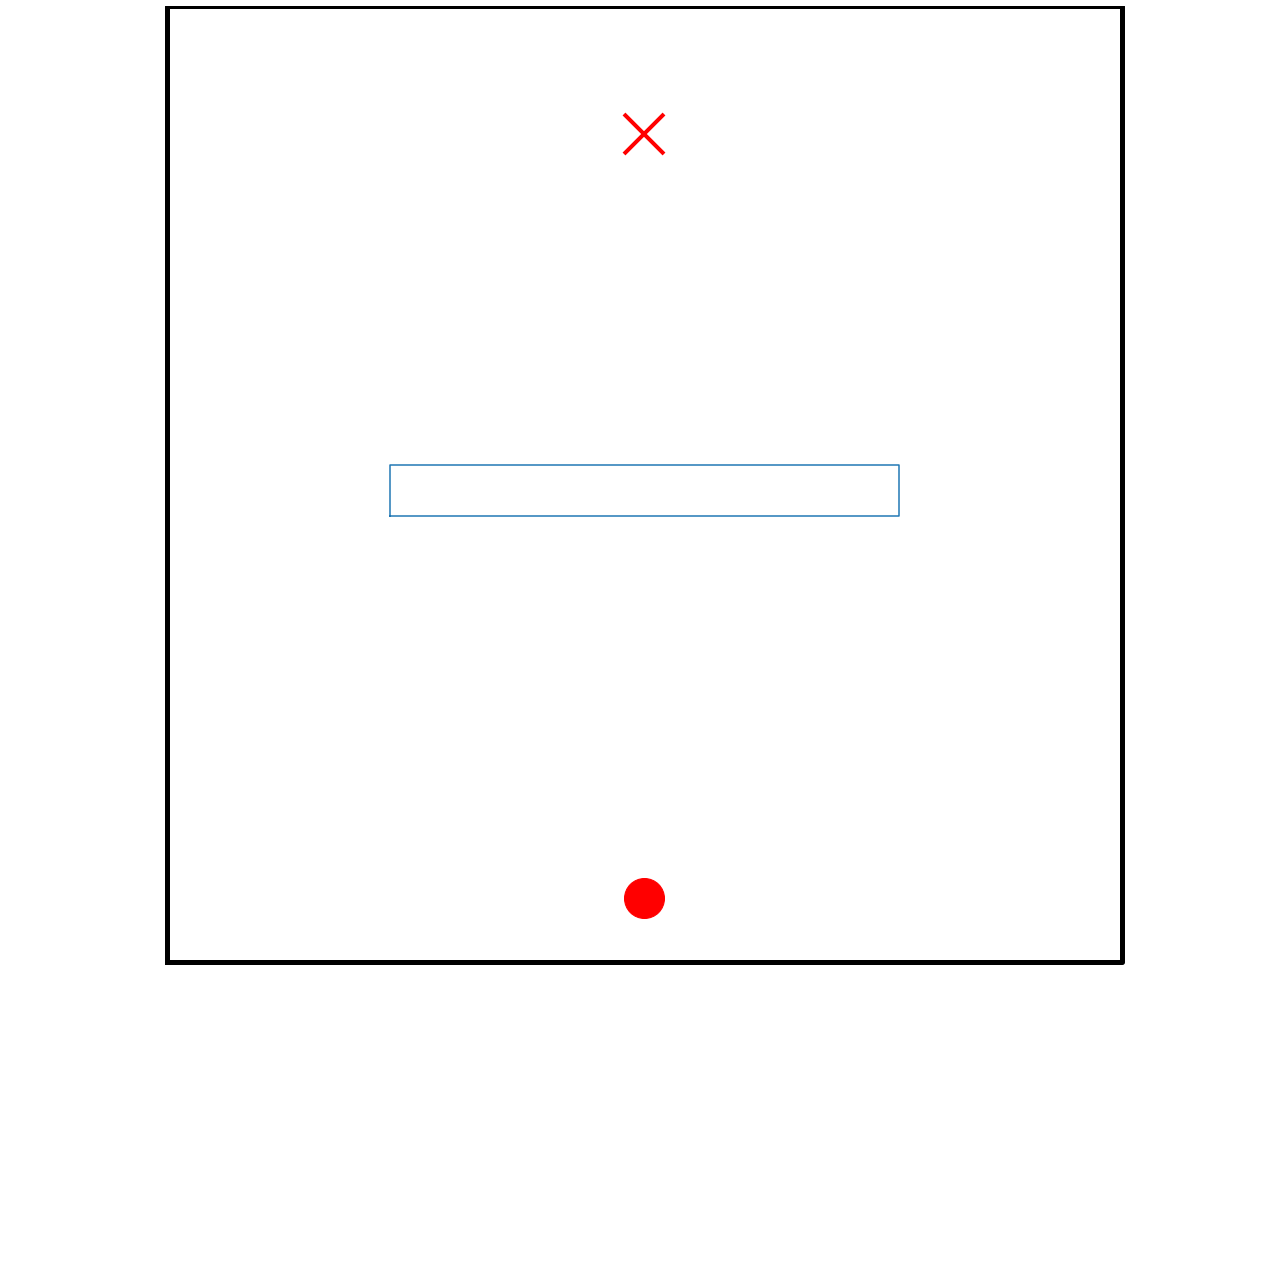

In [56]:
fig, ax, cmap = get_figure()
plot_map()    
make_figure_pretty(ax, fig)
fig.show()

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/

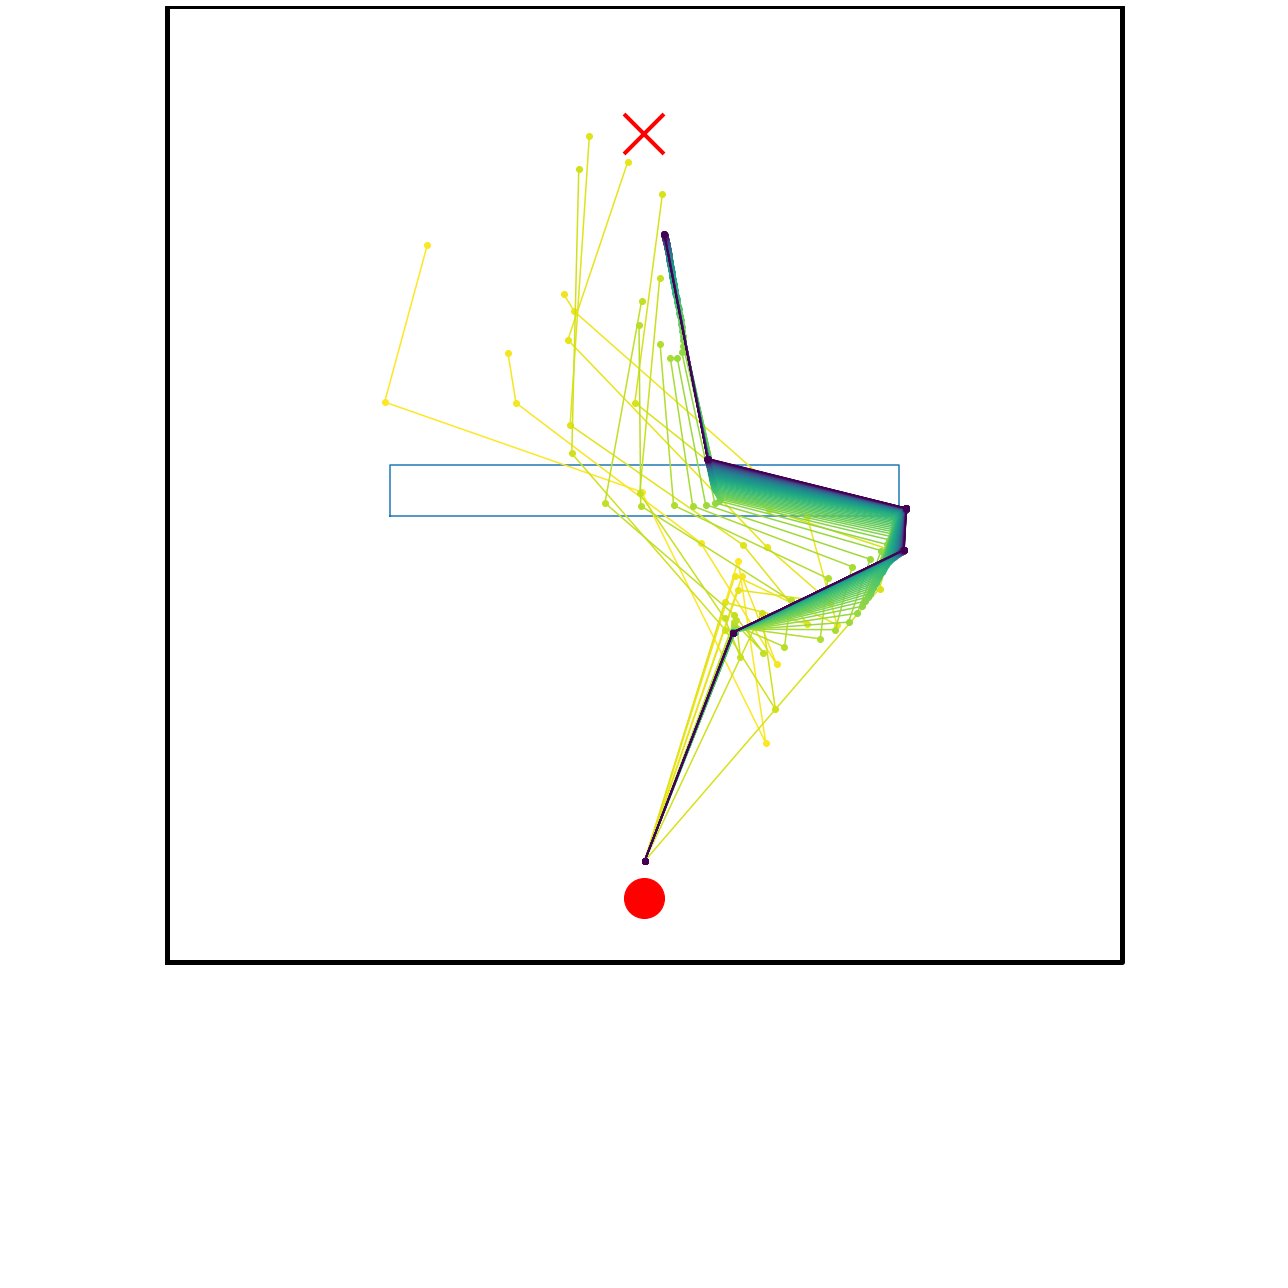

In [44]:
# Make video
plt_imgs = []
plot_plans = plans[16:100]
colors = np.linspace(1, 0, len(plot_plans))

fig, ax, cmap = get_figure()
plot_map()
    
for i, plan in enumerate(plot_plans):
    plan = plan[0, :6, :-2]
    states = agent._state(plan).mode()
    
    plt.plot(states[:, 1], states[:, 0], marker='o', color=cmap(colors[i]))
    
    make_figure_pretty(ax, fig)
    fig.show()
    img = fig2img(fig)
    plt_imgs.append(img)

In [46]:
video = np.stack(plt_imgs, 0)
print(video.max(), video.shape)
# video = np.concatenate([video,np.flip(video, 0)])

skvideo.io.vwrite(config.logdir_colloc / 'result_colloc.mp4', video, inputdict={'-r': '10'})
skvideo.io.vwrite(config.logdir_colloc / 'result_colloc.gif', video, inputdict={'-r': '5'})
# HTML('<img src="result.gif">')

255 (84, 1296, 1296, 3)


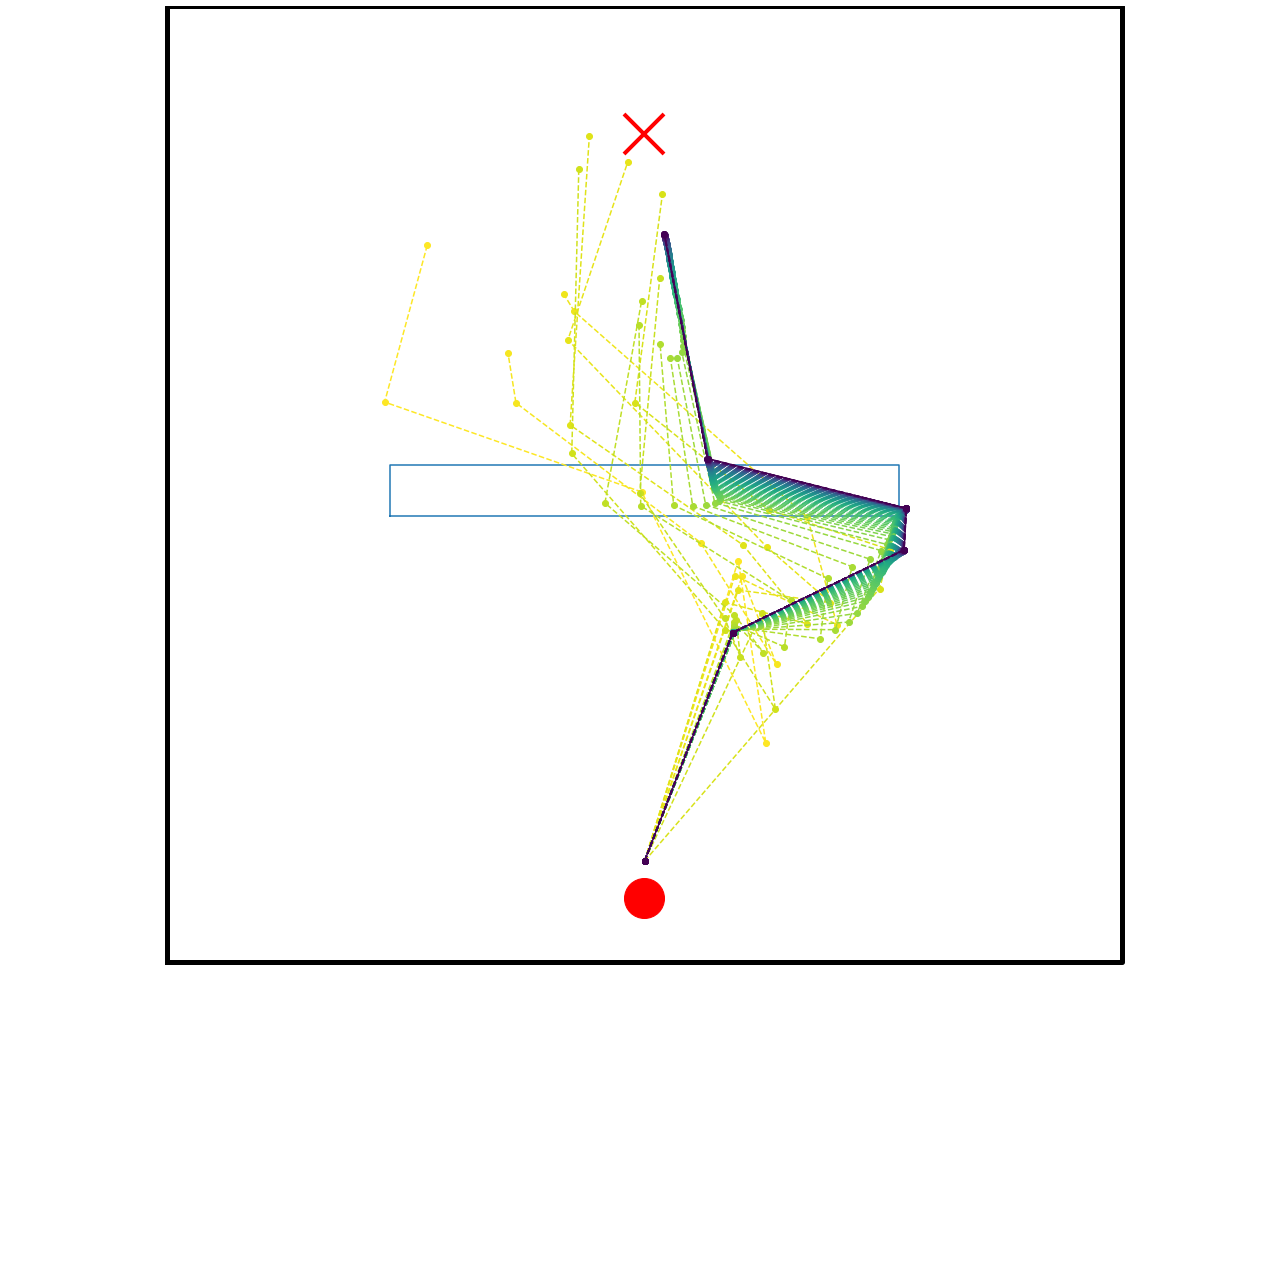

In [27]:
# Make collocation figure
plt_imgs = []
state_plans = []
for plan in plans[16:100]:
# for plan in plans[10:14]:
    plan = plan[0, :6, :-2]
    states = agent._state(plan).mode()
    state_plans.append(states)
    
fig, ax, cmap = get_figure()
colors = np.linspace(1, 0, len(plot_plans))

plot_map()

for i, states in enumerate(state_plans[:-1]):
    plt.plot(states[:, 1], states[:, 0], marker='o', ls='--', color=cmap(colors[i]))
plt.plot(state_plans[-1][:, 1], state_plans[-1][:, 0], marker='o', color=cmap(colors[-1]))

make_figure_pretty(ax, fig)
plt.show()
# imageio.imsave(config.logdir_colloc / 'visualization.jpg', img)

## Plot shooting CEM

In [70]:
## Plot shooting# Plot shooting

# args = '--logdir /scratch/robotic_video/collocation/pm_obstacle/dreamer/ --task colloc_pm_obstacle --action_repeat 1 --time_limit 40 --planning_task shooting_cem --batch_length 30 --planning_horizon 40 --mpc_steps 40 --logdir_colloc ./logdir_colloc/pm_obstacle/09_29_denseoffline800k_40x1_cem200_-0.4_0 --cem_steps 200 --metrics_fix True --eval_tasks 5'
# config = parser.parse_args(args.split(' '))
# agent.load(config.logdir / 'variables.pkl')

In [13]:
# Run shooting
# Define stuff
horizon = agent._c.planning_horizon
var_len = agent._actdim * agent._c.planning_horizon
batch = agent._c.cem_batch_size
init_feat, _ = agent.get_init_feat(obs)
elite_size = int(agent._c.cem_batch_size * agent._c.cem_elite_ratio)

# Sample
means = tf.zeros(var_len, dtype=agent._float)
stds = tf.ones(var_len, dtype=agent._float)
samples = tfd.MultivariateNormalDiag(means, stds).sample(sample_shape=[batch])
samples = tf.clip_by_value(samples, -1, 1)

# Evaluate
init_feats = tf.tile(init_feat, [batch, 1])
actions = tf.reshape(samples, [batch, horizon, -1])
feats = agent._dynamics.imagine_feat(actions, init_feats, deterministic=True)
fitness = tf.reduce_sum(agent._reward(feats).mode(), axis=1)
_, elite_inds = tf.nn.top_k(fitness, elite_size, sorted=False)
elite_samples = tf.gather(samples, elite_inds)
elite_plans = agent._state(feats).mode()
    
# Get elite states
# elite_samples.shape
# init_feats = tf.tile(init_feat, [100, 1])
# elite_feats = agent._dynamics.imagine_feat(tf.reshape(elite_samples, [100, horizon, -1]), init_feats, deterministic=True)
# elite_plans = agent._state(elite_feats).mode()

In [64]:
# elite_plans = [elite_plans.numpy() for plan in elite_plans]
# elite_plans = np.load(config.logdir_colloc / 'good_plans_collocation.npy')
# np.save(config.logdir_colloc / 'good_plans_shooting.npy', elite_plans)

elite_plans = np.load(config.logdir_colloc / 'good_plans_shooting.npy')
# Make collocation figure
state_plans = []
for plan in elite_plans[40:80]:
# for plan in plans[10:14]:
    plan = plan[:6, :-2]
    plan = np.concatenate([[[-0.4,0]], plan], 0)
    state_plans.append(plan)

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


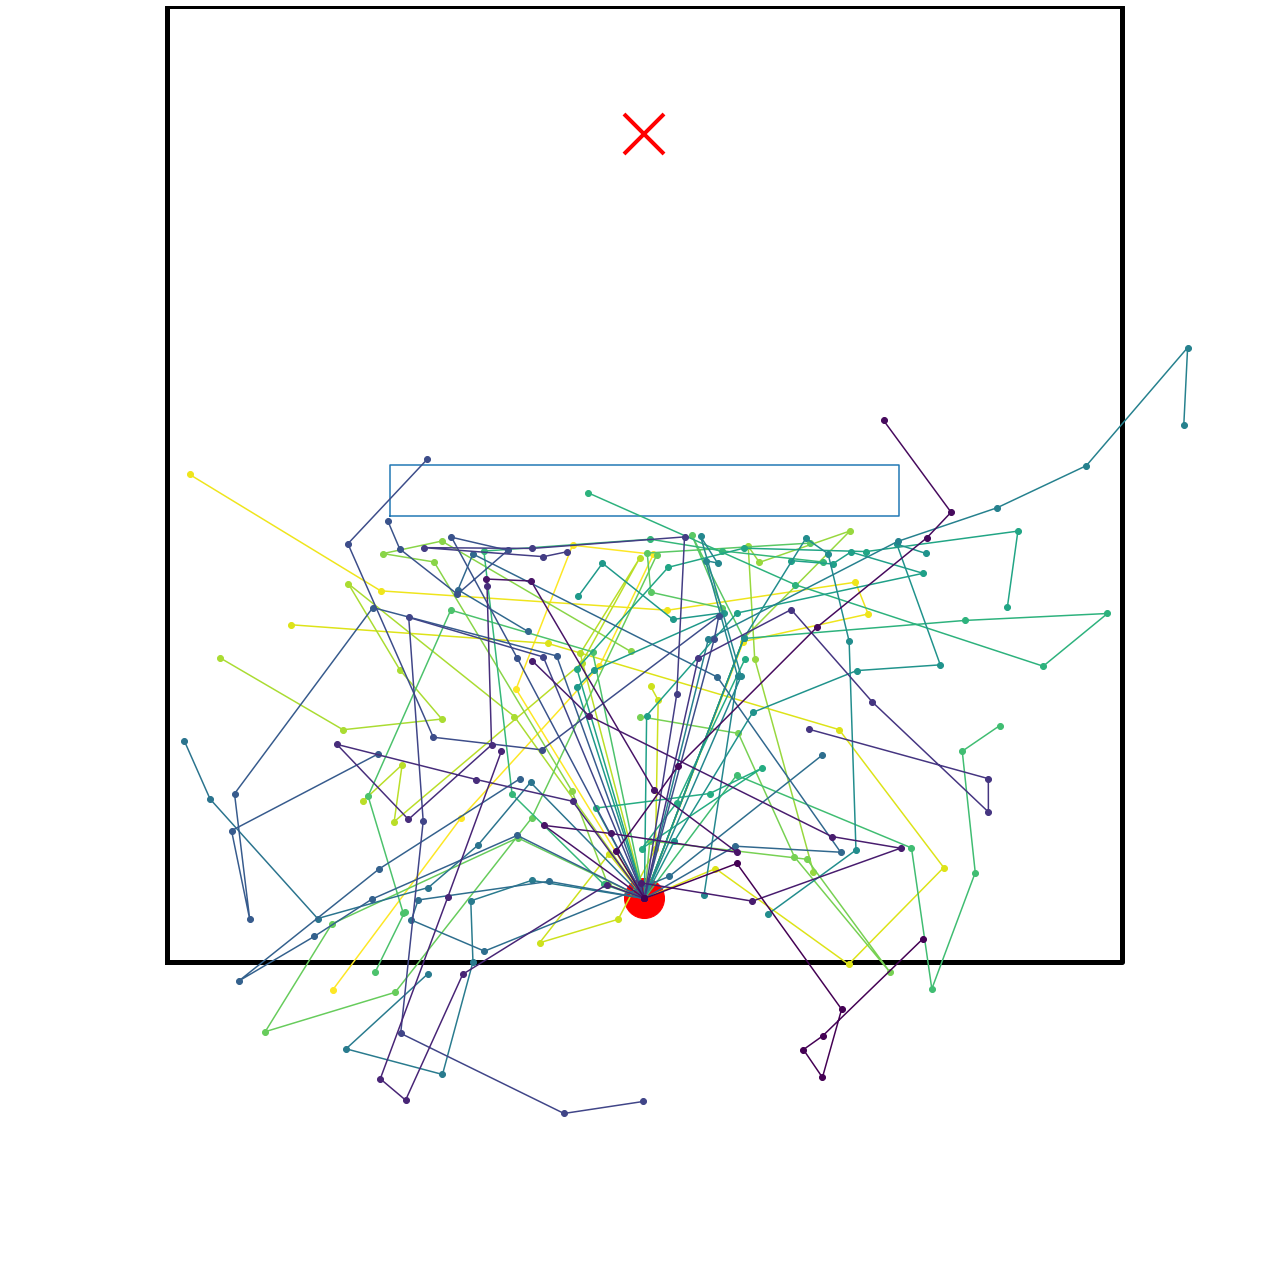

In [65]:
# Make video
plt_imgs = []
colors = np.linspace(1, 0, len(state_plans))

fig, ax, cmap = get_figure()
plot_map()
    
for i, plan in enumerate(state_plans):
    states = state_plans[i]
    
    plt.plot(states[:, 1], states[:, 0], marker='o', color=cmap(colors[i]))
    
    make_figure_pretty(ax, fig)
    fig.show()
    img = fig2img(fig)
    plt_imgs.append(img)

In [66]:
video = np.stack(plt_imgs, 0)
print(video.max(), video.shape)
# video = np.concatenate([video,np.flip(video, 0)])

skvideo.io.vwrite(config.logdir_colloc / 'result_shooting.mp4', video, inputdict={'-r': '10'})
skvideo.io.vwrite(config.logdir_colloc / 'result_shooting.gif', video, inputdict={'-r': '5'})
# HTML('<img src="result.gif">')

255 (40, 1296, 1296, 3)


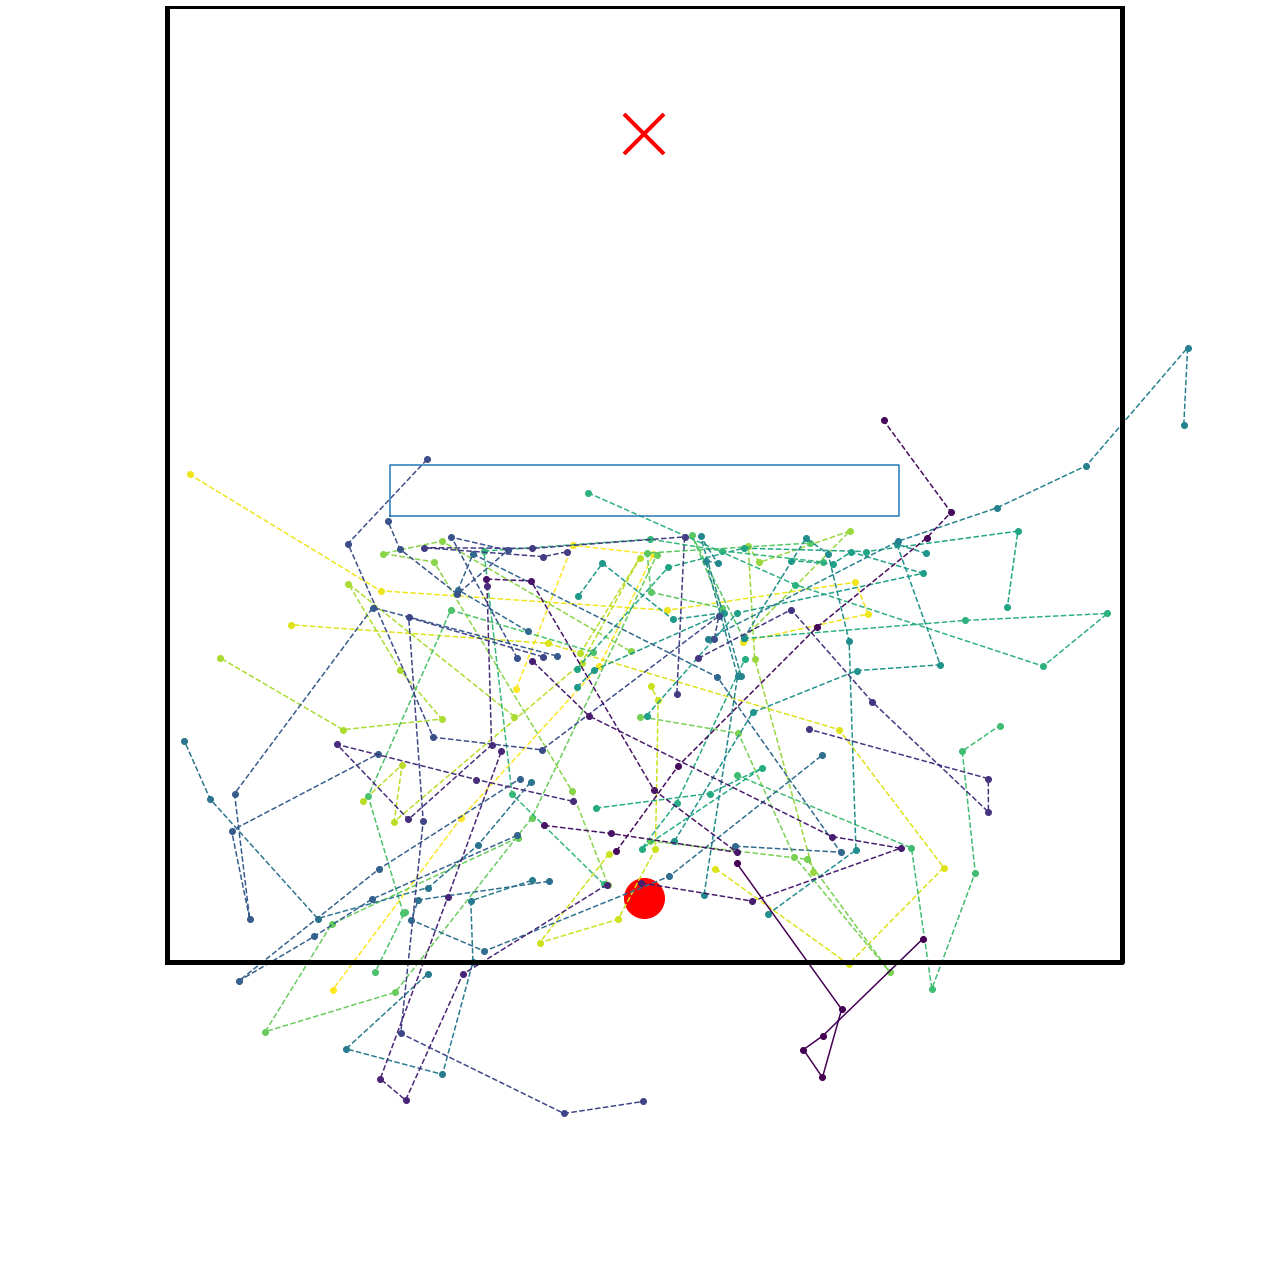

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [60]:
elite_plans = np.load(config.logdir_colloc / 'good_plans_shooting.npy')
# Make collocation figure
state_plans = []
for plan in elite_plans[40:80]:
# for plan in plans[10:14]:
    plan = plan[:6, :-2]
    state_plans.append(plan)
    
    

fig = plt.figure(figsize=(18,18))
ax = plt.gca()
plt.clf()  # Clear figure
colors = np.linspace(1, 0, len(state_plans))
cmap = plt.get_cmap()

plt.plot([0], [-0.4], 'ro', ms=40)
plt.plot([0], [0.8], 'rx', mew=4, ms=40)
for i, states in enumerate(state_plans[:-1]):
    plt.plot(states[:, 1], states[:, 0], marker='o', ls='--', color=cmap(colors[i]))
plt.plot(state_plans[-1][:, 1], state_plans[-1][:, 0], marker='o', color=cmap(colors[-1]))

x_min, x_max, y_min, y_max = 0.2, 0.28, -0.4, 0.4
plt.plot([y_min, y_max, y_max, y_min, y_min], [x_min, x_min, x_max, x_max, x_min,])

x_min, x_max, y_min, y_max = -0.5, 1, -0.75, 0.75
plt.plot([y_min, y_max, y_max, y_min, y_min], [x_min, x_min, x_max, x_max, x_min,], color='black', lw=5)

plt.xlim([-1, 1])
plt.ylim([-1, 1])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False)
ax.grid(False)
plt.axis('off')
fig.tight_layout()
plt.show()
img = fig2img(fig)
# imageio.imsave(config.logdir_colloc / 'visualization_shoot.jpg', img)

In [ ]:
import pylab as pl
import numpy as np

a = np.array([[0,1]])
pl.figure(figsize=(9, 1.5))
img = pl.imshow(a, cmap=cmap)
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="horizontal", cax=cax)
pl.savefig("colorbar.pdf")

## Plot Gradient Shooting

In [404]:
# Run shooting
# Define stuff
horizon = agent._c.planning_horizon
horizon = 10
var_len = agent._actdim * horizon
obs = env.reset()
obs['image'] = [obs['image']]
init_feat, _ = agent.get_init_feat(obs)
elite_size = int(agent._c.cem_batch_size * agent._c.cem_elite_ratio)

# Sample
means = tf.zeros(var_len, dtype=agent._float)
stds = tf.ones(var_len, dtype=agent._float)
samples = tfd.MultivariateNormalDiag(means, stds).sample(sample_shape=[1])
samplse = means[None]
samples = tf.clip_by_value(samples, -1, 1)

init_feats = tf.tile(init_feat, [1, 1])
actions = tf.reshape(samples, [1, horizon, -1])

shooting_gd_plans = []
# Optimize
for i in range(20):
    with tf.GradientTape() as tape:
        tape.watch(actions)
        feats = agent._dynamics.imagine_feat(actions, init_feats, deterministic=True)
        feats = tf.concat([init_feat[None], feats], 1)
        fitness = tf.reduce_sum(agent._reward(feats).mode(), axis=1)

    g = tape.gradient(fitness, actions)
    actions = actions + g * 0.05
    plans = agent._state(feats).mode()
    shooting_gd_plans.append(plans[0])
    
    
# Get elite states
# elite_samples.shape
# init_feats = tf.tile(init_feat, [100, 1])
# elite_feats = agent._dynamics.imagine_feat(tf.reshape(elite_samples, [100, horizon, -1]), init_feats, deterministic=True)
# elite_plans = agent._state(elite_feats).mode()

In [ ]:
means.shape

In [345]:
# elite_plans = [elite_plans.numpy() for plan in elite_plans]
# elite_plans = np.load(config.logdir_colloc / 'good_plans_collocation.npy')
# np.save(config.logdir_colloc / 'good_plans_shooting_gd.npy', elite_plans)
# elite_plans = np.load(config.logdir_colloc / 'good_plans_shooting.npy')

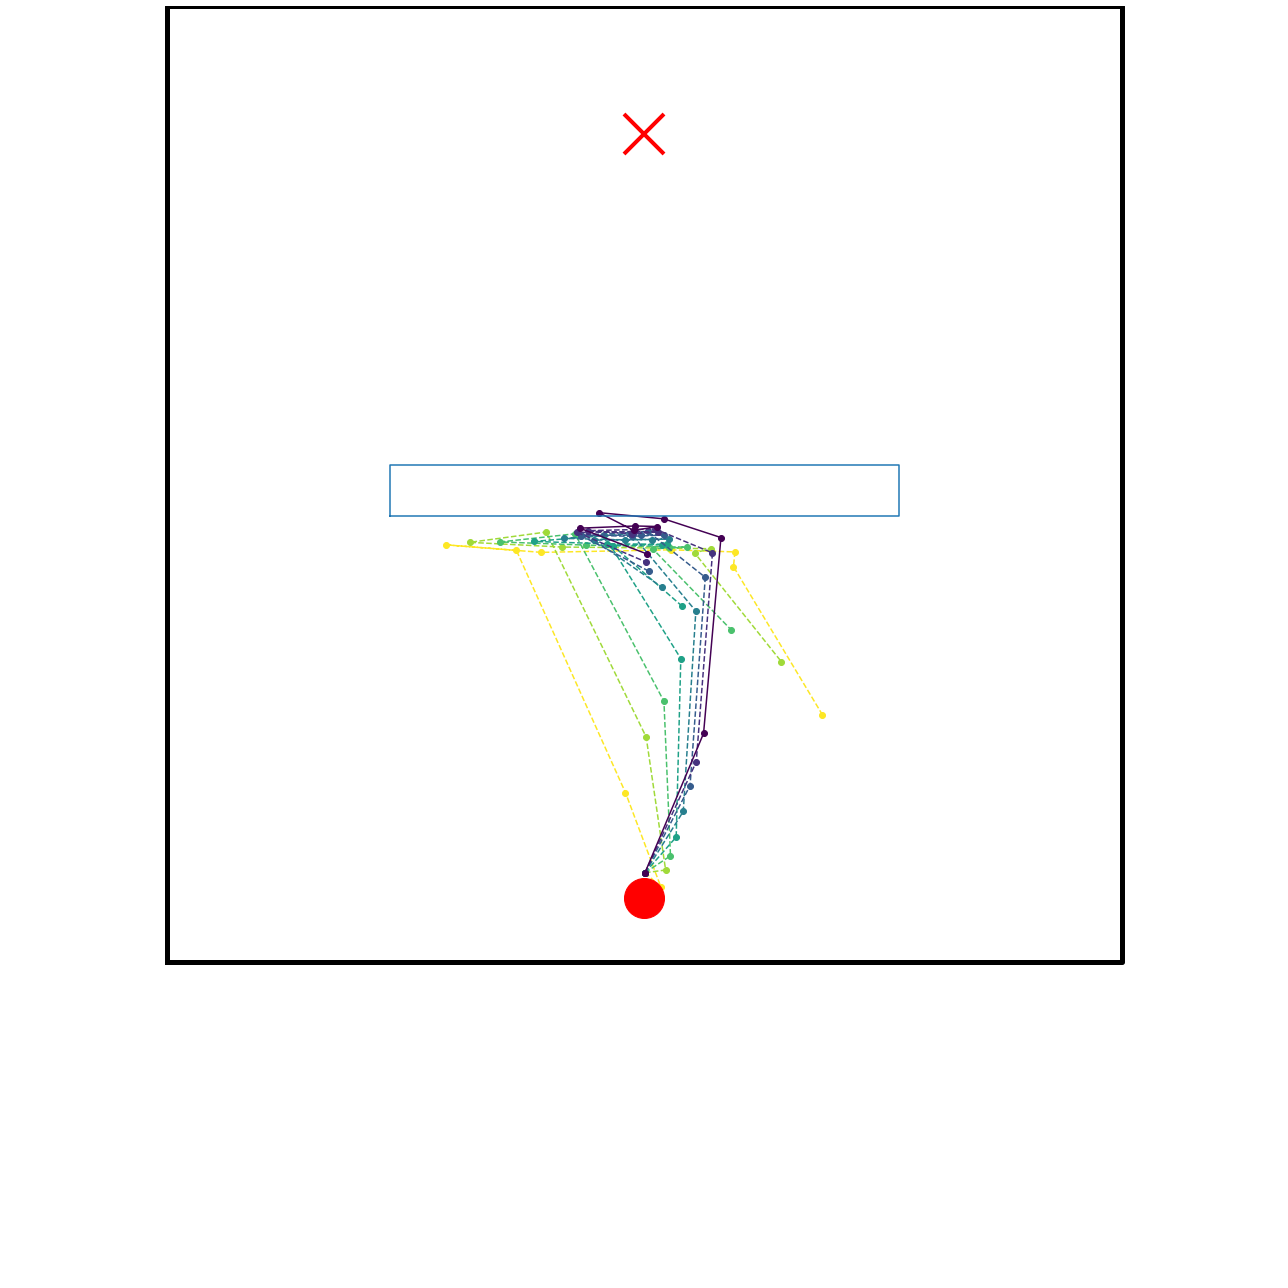

/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [409]:
# elite_plans = np.load(config.logdir_colloc / 'good_plans_shooting.npy')
# Make collocation figure
length = -1
state_plans = shooting_gd_plans[:8]
fig = plt.figure(figsize=(18,18))
ax = plt.gca()
plt.clf()  # Clear figure
colors = np.linspace(1, 0, len(state_plans))
cmap = plt.get_cmap()

for i, states in enumerate(state_plans[:-1]):
    plt.plot(states[:length, 1], states[:length, 0], marker='o', ls='--', color=cmap(colors[i]))
plt.plot(state_plans[-1][:length, 1], state_plans[-1][:length, 0], marker='o', color=cmap(colors[-1]))

x_min, x_max, y_min, y_max = 0.2, 0.28, -0.4, 0.4
plt.plot([y_min, y_max, y_max, y_min, y_min], [x_min, x_min, x_max, x_max, x_min,])
x_min, x_max, y_min, y_max = -0.5, 1, -0.75, 0.75
plt.plot([y_min, y_max, y_max, y_min, y_min], [x_min, x_min, x_max, x_max, x_min,], color='black', lw=5)

plt.plot([0], [-0.4], 'ro', ms=40)
plt.plot([0], [0.8], 'rx', mew=4, ms=40)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False)
ax.grid(False)
plt.axis('off')
fig.tight_layout()
plt.show()
img = fig2img(fig)
# imageio.imsave(config.logdir_colloc / 'visualization_shoot.jpg', img)

## Plot gradient

In [6]:
agent._c.gd_steps=1
act_pred, img_pred, feat_pred, info = agent.collocation_so(obs, goal_obs, True, 0)
plans = info['plans']
# agent.logger.log_video(f"plan/0", img_pred.numpy())

Final average dynamics loss: 8.726728992769495e-07
Final average action violation: 2.8610230629055877e-07
Final total reward: -14.780536651611328
Final average initial state violation: 3.417570740293918e-11


In [75]:
# Get the (approximate) derivative of the reward with respect to the true state
def get_drds(z):
    with tf.GradientTape(persistent=True) as tape: 
        tape.watch(z)
        r = agent._reward(z).mode()[:, None]
        s = agent._state(z).mode()

    drdz = tape.batch_jacobian(r, z)
    dsdz = tape.batch_jacobian(s, z)
    dzds = tf.linalg.pinv(dsdz)
    drds = tf.linalg.matmul(drdz, dzds) 
    return drds

def plot_arrows(x, y, dx, dy, **kwargs):
    for i in range(x.shape[0]):
        plt.arrow(x[i], y[i], dx[i], dy[i], **kwargs)

In [163]:
drds = get_drds(plans[-1][0,:,:-2])
# drds[:6, 0].shape
gradients = drds[:6, 0, :2] * 0.05
# gradients

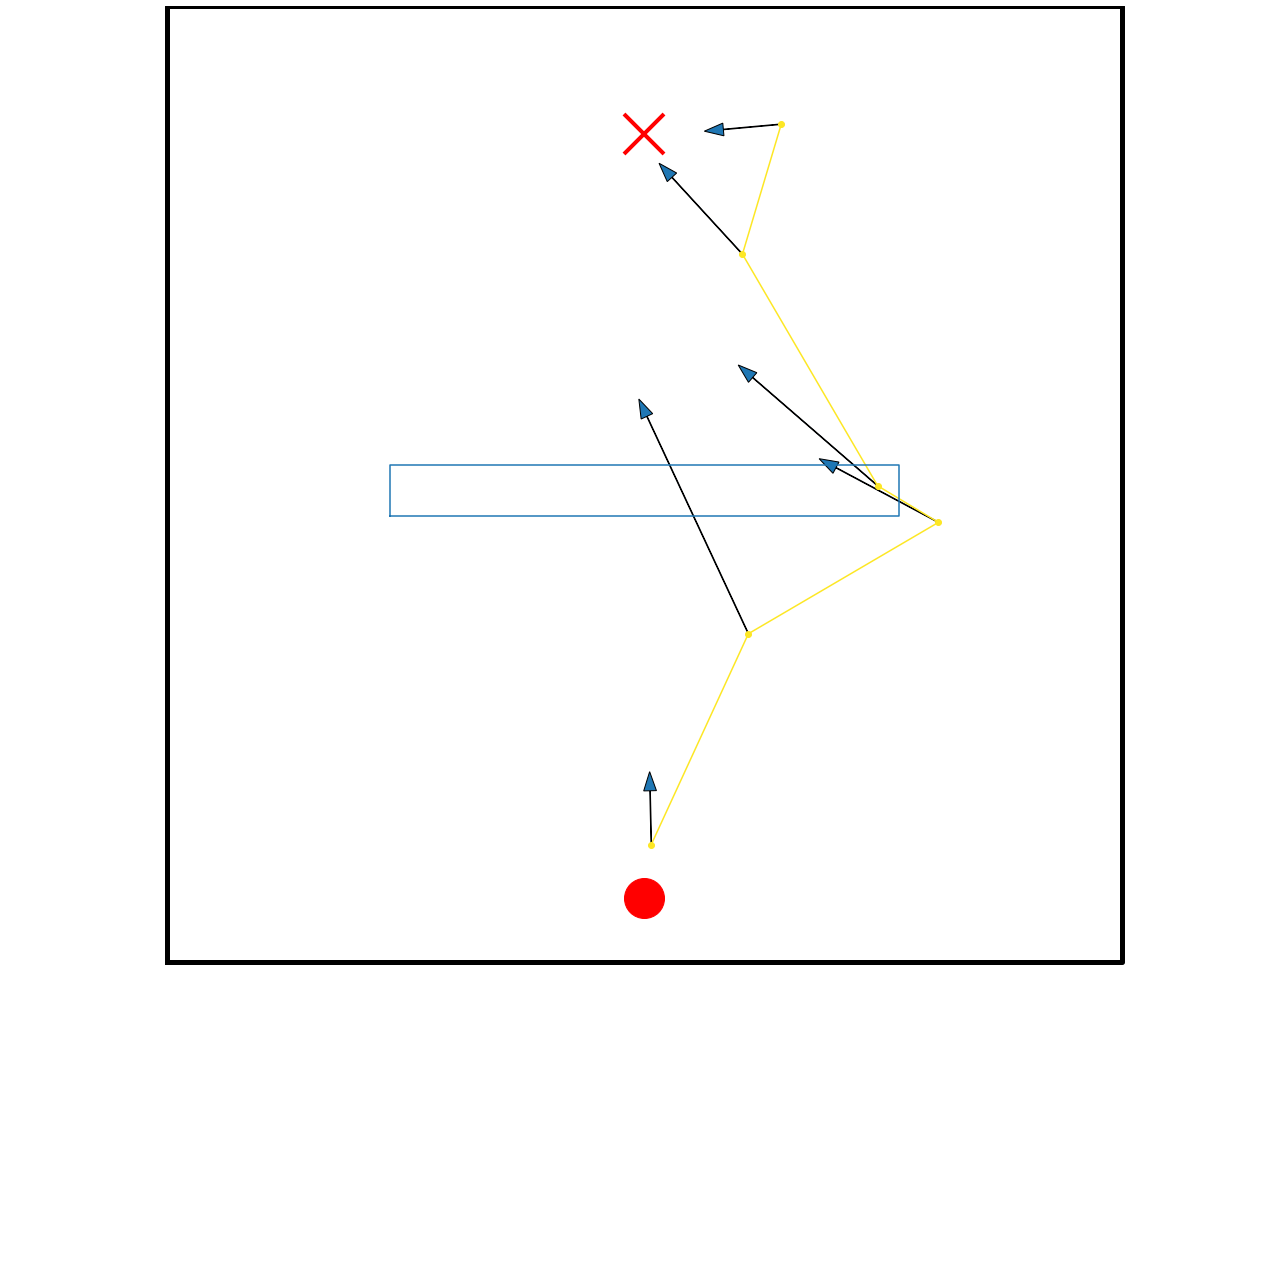

In [124]:
# Make collocation figure

# Make state plans
plt_imgs = []
state_plans = []
for plan in plans[-1:]:
# for plan in plans[10:14]:
    plan = plan[0, :6, :-2]
    states = agent._state(plan).mode()
    state_plans.append(states)
# Init figure
cmap = plt.get_cmap() 
fig = plt.figure(figsize=(18,18))
ax = plt.gca()
plt.clf()  # Clear figure
colors = np.linspace(1, 0, len(state_plans))

# Trajectory
plt.plot([0], [-0.4], 'ro', ms=40)
plt.plot([0], [0.8], 'rx', mew=4, ms=40)
for i, states in enumerate(state_plans[:-1]):
    plt.plot(states[:, 1], states[:, 0], marker='o', ls='--', color=cmap(colors[i]))
plt.plot(state_plans[-1][:, 1], state_plans[-1][:, 0], marker='o', color=cmap(colors[-1]))

# Gradient
# plt.arrow(state_plans[-1][-1, 1], state_plans[-1][-1, 0], gradients[-1, 1], gradients[-1, 0], head_width=0.02)
plot_arrows(state_plans[-1][:, 1], state_plans[-1][:, 0], gradients[:, 1], gradients[:, 0], head_width=0.02)

# Obstacle
x_min, x_max, y_min, y_max = 0.2, 0.28, -0.4, 0.4
plt.plot([y_min, y_max, y_max, y_min, y_min], [x_min, x_min, x_max, x_max, x_min,])
# Border
x_min, x_max, y_min, y_max = -0.5, 1, -0.75, 0.75
plt.plot([y_min, y_max, y_max, y_min, y_min], [x_min, x_min, x_max, x_max, x_min,], color='black', lw=5)
# Make pretty
plt.xlim([-1, 1])
plt.ylim([-1, 1])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False)
ax.grid(False)
plt.axis('off')
fig.tight_layout()
plt.show()
# img = fig2img(fig)
# imageio.imsave(config.logdir_colloc / 'visualization.jpg', img)

## Get reward gradient at each state dr/ds

In [85]:
def render_img_from_state(state):
    _env = env._env._env._env
    _env.do_reset(state, 0.0*_env.init_qvel.copy(), np.array([0.8, 0.0, 0]))
    # observation, _reward, done, _info = _env._step(np.zeros(2))
    ob = _env._get_obs()

    # Get image
    env._offscreen.render(env._width, env._width, -1)
    image = np.flip(env._offscreen.read_pixels(env._width, env._width)[0], 1)
    feat, _ = agent.get_init_feat({'image': image[None], 'reward': np.zeros(1)})
    return image, feat

def centered_arrow(x, y, dx, dy, **kwargs):
    plt.arrow(x - dx/2, y - dy/2, dx, dy, **kwargs)

In [472]:
min_i, max_i = -.5, 1
min_j, max_j = -.75, .75

min_i, max_i = 0, 0.23
min_j, max_j = -.4, .4
n_i = 10
n_j = 30

obs_minx, obs_maxx, obs_miny, obs_maxy = 0.1, 0.4, -0.55, 0.55
def is_in_obs(x, y):
    return x > obs_minx and x < obs_maxx and y > obs_miny and y < obs_maxy

grid_states = []
grid_gradients = []
grid_feats = []
for i in np.linspace(min_i, max_i, n_i):
    for j in np.linspace(min_j, max_j, n_j):
        state = np.array([i, j])
        _, feat = render_img_from_state(state)
        grid_states.append(state)
        grid_feats.append(feat)
#         gradients = get_drds(feat) * 0.05
#         grid_gradients.append(gradients)
grid_gradients = get_drds(tf.concat(grid_feats, 0))[:, None] * 0.05

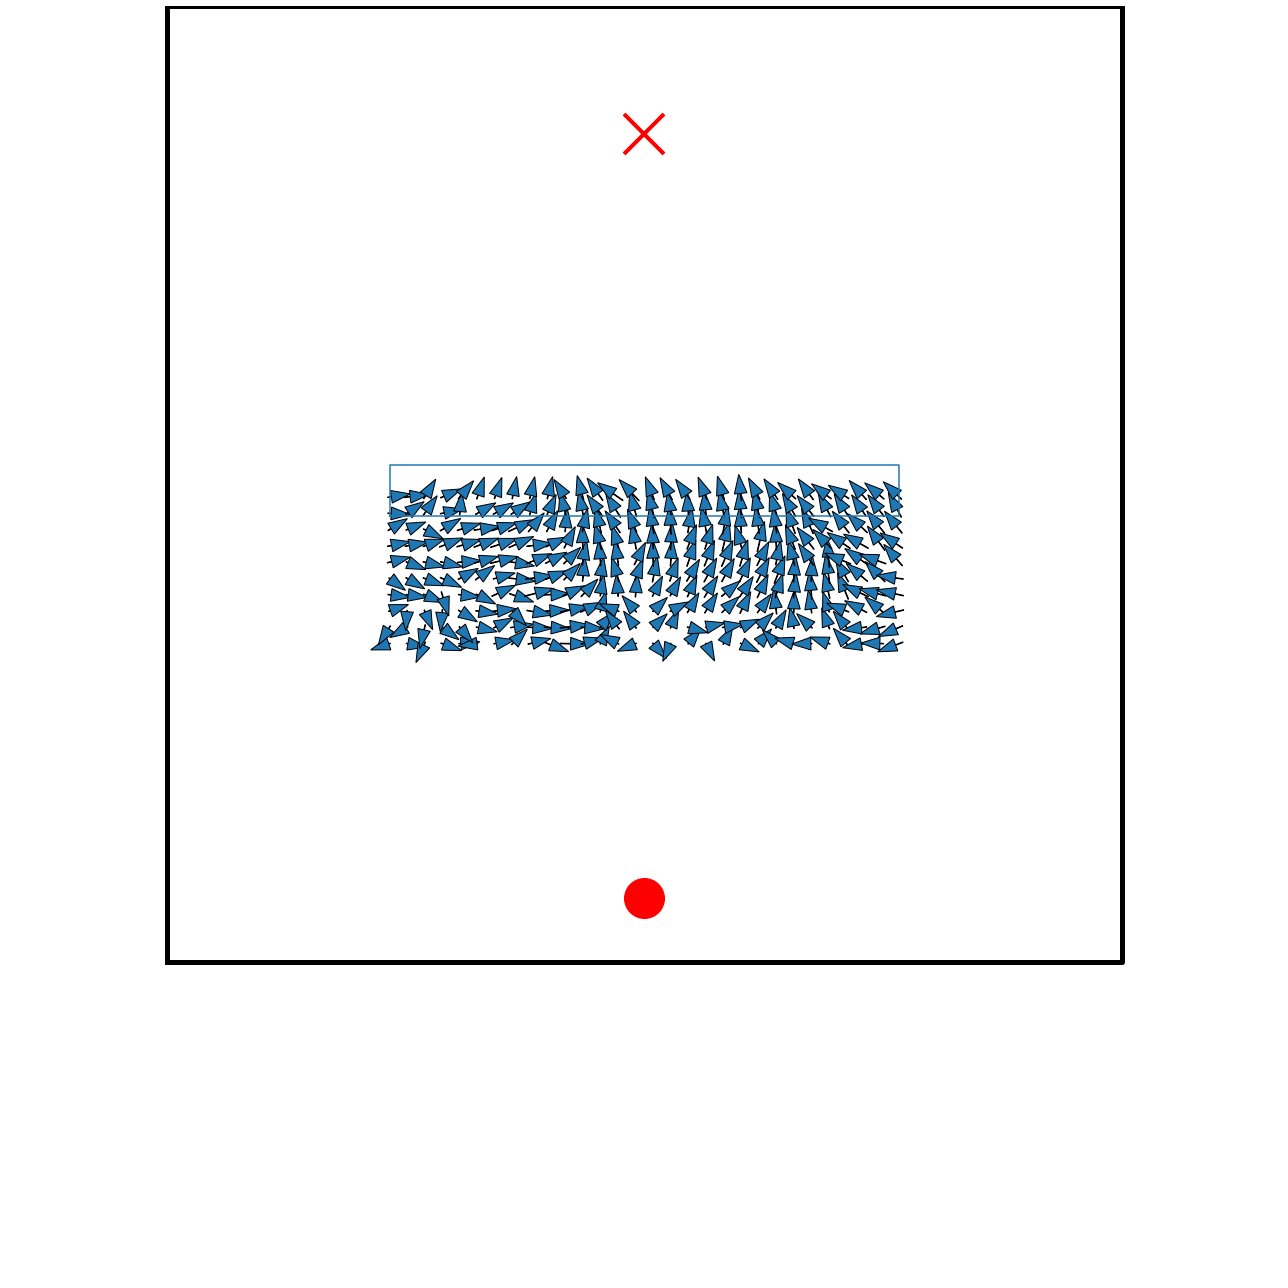

In [475]:
grad_scale = 1 / 20

fig, ax, cmap = get_figure()
plot_map()
colors = np.linspace(1, 0, len(state_plans))

tf.linalg.norm(grid_gradients, axis=-1)

for i, (state, gradients) in enumerate(zip(grid_states, grid_gradients)):
#     if is_in_obs(i, j):
#         continue
    centered_arrow(state[1], state[0], gradients[0,0,1] * grad_scale, gradients[0,0,0] * grad_scale, head_width=0.02)

# Make pretty
make_figure_pretty(ax, fig)
plt.show()

In [481]:
tf.reduce_mean(grid_gradients)


TensorShape([300, 1, 1])

## Dr/da

In [254]:
def get_drda(z, a):
    with tf.GradientTape(persistent=True) as tape: 
        tape.watch(a)
        next_z = agent._dynamics.imagine_feat(a[:, None], z, deterministic=True)
        r = agent._reward(next_z).mode()

    drda = tape.batch_jacobian(r, a)
    return drda

In [470]:
min_i, max_i = -.5, 1
min_j, max_j = -.75, .75

min_i, max_i = 0, 0.23
min_j, max_j = -.4, .4
n_i = 10
n_j = 30

obs_minx, obs_maxx, obs_miny, obs_maxy = 0.1, 0.4, -0.55, 0.55
def is_in_obs(x, y):
    return x > obs_minx and x < obs_maxx and y > obs_miny and y < obs_maxy

grid_states = []
grid_gradients = []
grid_feats = []
for i in np.linspace(min_i, max_i, n_i):
    for j in np.linspace(min_j, max_j, n_j):
        state = np.array([i, j])
        _, feat = render_img_from_state(state)        
        grid_states.append(state)
        grid_feats.append(feat)
#         gradients = get_drds(feat) * 0.05
#         grid_gradients.append(gradients)

actions = tf.cast(tf.stack(grid_states, 0), float)
grid_gradients = get_drda(tf.concat(grid_feats, 0), actions)[:, None] * 0.05

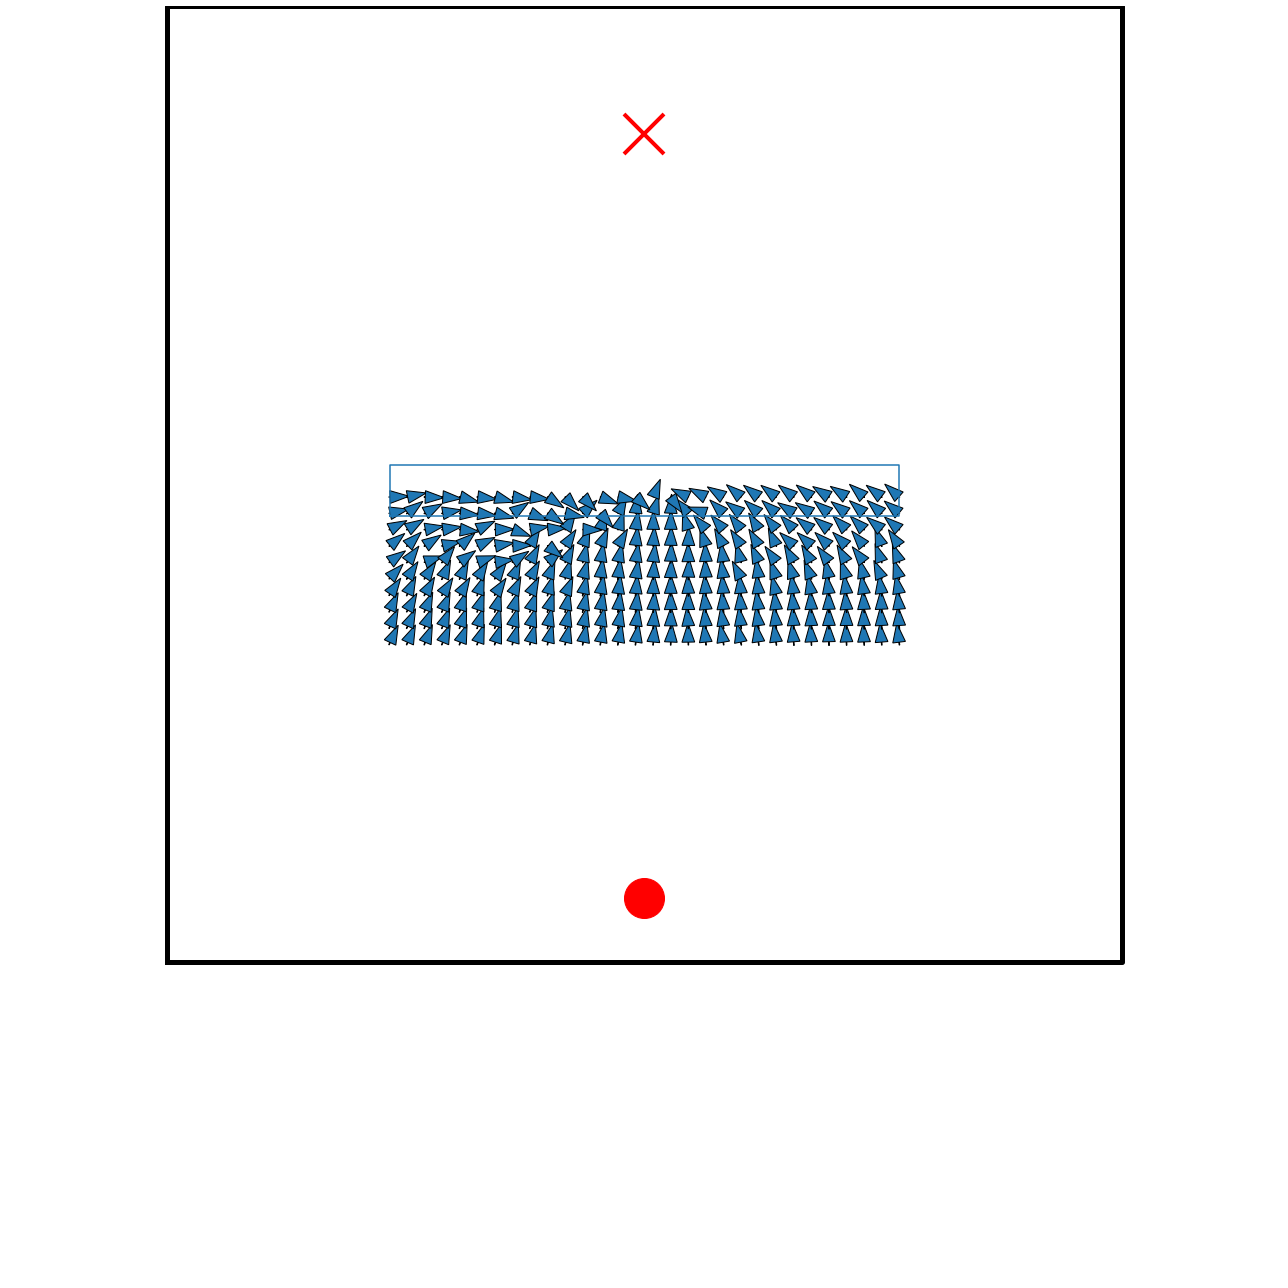

In [471]:
grad_scale = 1 / 20

fig, ax, cmap = get_figure()
plot_map()
colors = np.linspace(1, 0, len(state_plans))

for state, gradients in zip(grid_states, grid_gradients):
#     if is_in_obs(state[0], state[1]):
#         continue
    centered_arrow(state[1], state[0], gradients[0,0,1] * grad_scale, gradients[0,0,0] * grad_scale, head_width=0.02)

# Make pretty
make_figure_pretty(ax, fig)
plt.show()

In [426]:
i, j = 1, 0
state = np.array([i, j])
img, z = render_img_from_state(state)
plt.imshow(img)

In [402]:
# Inspection that shows why the gradient points beyond obstacle - the model is inaccurate
i, j = 0.8, 0
state = np.array([i, j])
_, z = render_img_from_state(state)
a = tf.convert_to_tensor([i, j], dtype=float)[None]

with tf.GradientTape(persistent=True) as tape: 
    tape.watch(a)
    next_z = agent._dynamics.imagine_feat(a[:, None], z, deterministic=True)
    r = agent._reward(next_z).mode()

drda = tape.batch_jacobian(r, a)
    
r, drda, agent._state(next_z).mode()[0,0,:2]

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.10759624]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[ 0.24617982, -0.01025966]]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.6441555 , 0.02344208], dtype=float32)>)

In [422]:
a = tf.convert_to_tensor([1, 0], dtype=float)[None]
next_z = agent._dynamics.imagine_feat(a[:, None], z, deterministic=True)
agent._state(z).mode()[0, :2], agent._state(next_z).mode()[0,0,:2]

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.7540875 , 0.01934738], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.6774367, 0.0236312], dtype=float32)>)

## Show optimization trajectory for a single state

In [340]:
_, feat = render_img_from_state(np.array([-.4, 0.]))
print(agent._state(feat).mode()[0,:2].numpy())

traj_feats = [feat]
for i in range(15):
    with tf.GradientTape(persistent=True) as tape: 
        tape.watch(feat)
        r = agent._reward(feat).mode()[:, None]

    g = tape.gradient(r, feat)
    feat = feat + 0.2 * g
    print(agent._state(feat).mode()[0,:2].numpy())
    traj_feats.append(feat)


[-0.36935255  0.01255214]
[-0.34267077  0.03348521]
[-0.26075336  0.06394275]
[-0.2097871   0.08584697]
[-0.03819942  0.05851664]
[0.15785584 0.0400768 ]
[0.3850951  0.03240129]
[0.49709195 0.02533523]
[0.57579184 0.01823239]
[0.6209455  0.01047499]
[0.6380718  0.00698993]
[0.6487662 0.0052651]
[0.6574845  0.00394751]
[0.6650432  0.00282189]
[0.6710983  0.00203074]
[0.6756086  0.00162639]


In [344]:
# np.save(config.logdir_colloc / 'good_plans_single_state.npy', traj_feats)
traj_feats = np.load(config.logdir_colloc / 'good_plans_single_state.npy')

In [351]:
traj.shape

TensorShape([16, 1, 230])

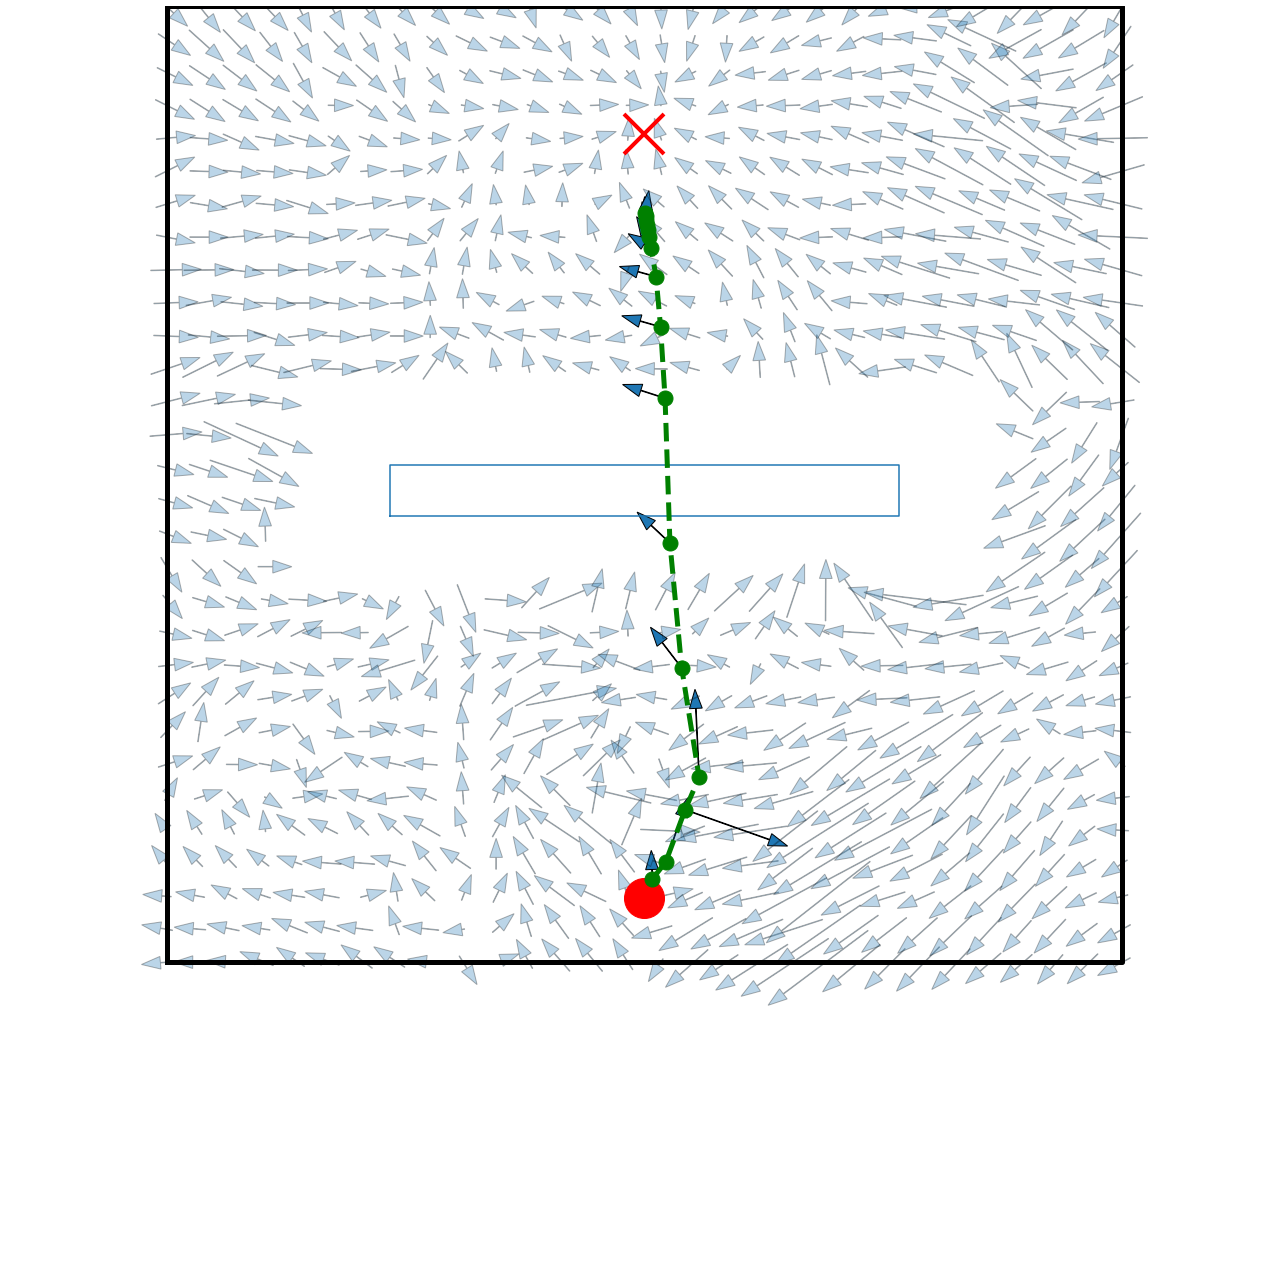

In [359]:
# Show optimization trajectory for a single state

traj = tf.concat(traj_feats[:, 0], 0)
state_traj = agent._state(traj).mode()
gradients = get_drds(traj)[:, 0] * 0.02
# Init figure
fig, ax, cmap = get_figure()
plot_map()
colors = np.linspace(1, 0, len(state_plans))

# Optimization Trajectory
plt.plot(state_traj[:, 1], state_traj[:, 0], 'go--', lw=5, ms=15)
plot_arrows(state_traj[:, 1], state_traj[:, 0], gradients[:, 1], gradients[:, 0], head_width=0.02)

if True:
    for state, gradients in zip(grid_states, grid_gradients):
        centered_arrow(state[1], state[0], gradients[0,0,1] / 3, gradients[0,0,0] / 3, head_width=0.02, alpha=0.3)

make_figure_pretty(ax, fig)
plt.show()

In [ ]:
grad_scale = 1 / 3

fig, ax, cmap = get_figure()
plot_map()
colors = np.linspace(1, 0, len(state_plans))

for state, gradients in zip(grid_states, grid_gradients):
#     if is_in_obs(state[0], state[1]):
#         continue
    centered_arrow(state[1], state[0], gradients[0,0,1] * grad_scale, gradients[0,0,0] * grad_scale, head_width=0.02)

# Make pretty
make_figure_pretty(ax, fig)
plt.show()